EXAMPLE BUILT FROM: https://www.section.io/engineering-education/building-spotify-recommendation-engine/

In [ ]:
!pip install spotipy --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 6.0 MB/s eta 0:00:00


In [ ]:
import os

os.environ["CLIENT_ID"] = '6972ee4b5ef24baabfe021463cf6cc93'
os.environ["CLIENT_SECRET"] = "dc3fd5689ed44f858b353a441cec2e8b"

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

SPOTIFY DATASET DOWNLOAD FROM HERE: 
https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db

In [ ]:
spotify_data = pd.read_csv('/content/SpotifyFeatures.csv')
spotify_data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [ ]:
spotify_features_df = spotify_data
genre_OHE = pd.get_dummies(spotify_features_df.genre)
key_OHE = pd.get_dummies(spotify_features_df.key)

In [ ]:
scaled_features = MinMaxScaler().fit_transform([
  spotify_features_df['acousticness'].values,
  spotify_features_df['danceability'].values,
  spotify_features_df['duration_ms'].values,
  spotify_features_df['energy'].values,
  spotify_features_df['instrumentalness'].values,
  spotify_features_df['liveness'].values,
  spotify_features_df['loudness'].values,
  spotify_features_df['speechiness'].values,
  spotify_features_df['tempo'].values,
  spotify_features_df['valence'].values,
  ])

In [ ]:
#Storing the transformed column vectors into our dataframe
spotify_features_df[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']] = scaled_features.T

In [ ]:
#discarding the categorical and unnecessary features 
spotify_features_df = spotify_features_df.drop('genre',axis = 1)
spotify_features_df = spotify_features_df.drop('artist_name', axis = 1)
spotify_features_df = spotify_features_df.drop('track_name', axis = 1)
spotify_features_df = spotify_features_df.drop('popularity',axis = 1)
spotify_features_df = spotify_features_df.drop('key', axis = 1)
spotify_features_df = spotify_features_df.drop('mode', axis = 1)
spotify_features_df = spotify_features_df.drop('time_signature', axis = 1)

In [ ]:
#Appending the OHE columns of the categorical features
spotify_features_df = spotify_features_df.join(genre_OHE)
spotify_features_df = spotify_features_df.join(key_OHE)

In [ ]:
spotify_features_df.head()


,track_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,B,C,C#,D,D#,E,F,F#,G,G#
0,0BRjO6ga9RKCKjfDqeFgWV,0.000025,0.000022,1.0,0.000028,0.000018,0.000022,0.0,0.000019,0.001699,...,0,0,1,0,0,0,0,0,0,0
1,0BjC1NfoEOOusryehmNudP,0.000042,0.000045,1.0,0.000046,0.000040,0.000042,0.0,0.000041,0.001307,...,0,0,0,0,0,0,0,1,0,0
2,0CoSDzoNIKCRs124s9uTVy,0.000087,0.000085,1.0,0.000082,0.000082,0.000082,0.0,0.000082,0.000666,...,0,1,0,0,0,0,0,0,0,0
3,0Gc6TVm52BwZD07Ki6tIvf,0.000084,0.000081,1.0,0.000082,0.000080,0.000081,0.0,0.000080,0.001207,...,0,0,1,0,0,0,0,0,0,0
4,0IuslXpMROHdEPvSl1fTQK,0.000267,0.000260,1.0,0.000259,0.000257,0.000258,0.0,0.000256,0.001957,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
scope = 'user-library-read'
sp = spotipy.Spotify(
        auth_manager=spotipy.SpotifyOAuth(
          client_id='6972ee4b5ef24baabfe021463cf6cc93',
          client_secret= "dc3fd5689ed44f858b353a441cec2e8b",
          redirect_uri="https://example.com/callback/",    
          scope=scope, open_browser=False))

playlist_dic = {}
playlist_cover_art = {}

for i in sp.current_user_playlists()['items']:
    playlist_dic[i['name']] = i['uri'].split(':')[2]
    playlist_cover_art[i['uri'].split(':')[2]] = i['images'][0]['url']

print(playlist_dic)

Go to the following URL: https://accounts.spotify.com/authorize?client_id=6972ee4b5ef24baabfe021463cf6cc93&response_type=code&redirect_uri=https%3A%2F%2Fexample.com%2Fcallback%2F&scope=user-library-read
Enter the URL you were redirected to: https://example.com/callback/?code=AQAdywsVd2pGQBqsipecz105dC_OYyE3Kqp5uCB0NTYRR4r_Y6t8PbFz4p-FjA6TQUtWzYD4ZFEy9IWokxKPAlkyF-w6uA5QHiuJF19Wiw0AKkeuSMVK6auPC-ZwTbJ3EF0yk5YZSFOLZtxhVDCj7n-tWiWJPEz_3pEkfGWJKUTF8RVVW5CQWp1riHkdHUTLljsT7w
{'ds3 test': '6fYlHIgV59xtTZ0WwdmJQx', 'daily dose of serotonin': '41pZbcNUtkmshI7Vo29EZN', 'all the valid mfs from toronto': '5rcd5YXasFveflpTSUWCPy', 'ind(ie)z nuts': '2IwkHHSDW17WVq7P8zx2Vf', 'manipulative melodies': '2SLnyO4oCqCu20Di6CW2hQ', 'puffed up on zootiez': '5y6ILbC144NwEjrCEu2pgx', 'things that stop you dreaming': '5NEglG3v0rlHEOLLq2tLGh', 'lemme get aux rq': '6ilL70NNyUh8wH2DDzeHNE', 'stealing ud’s music taste': '40OM3Ev8zMox7I1zbpnU7T', 'Foolin foolers': '5wHcVPOJjJspgVad2D6HfF', 'On Repeat': '37i9dQZF1Ep

In [ ]:
#creating the playlist dataframe with extended features using Spotify data

def generate_playlist_df(playlist_name, playlist_dic, spotify_data):
    
    playlist = pd.DataFrame()

    for i, j in enumerate(sp.playlist(playlist_dic[playlist_name])['tracks']['items']):
        playlist.loc[i, 'artist'] = j['track']['artists'][0]['name']
        playlist.loc[i, 'track_name'] = j['track']['name']
        playlist.loc[i, 'track_id'] = j['track']['id']
        playlist.loc[i, 'url'] = j['track']['album']['images'][1]['url']
        playlist.loc[i, 'date_added'] = j['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['track_id'].isin(spotify_data['track_id'].values)].sort_values('date_added',ascending = False)

    return playlist
playlist_df = generate_playlist_df('ds3 test', playlist_dic, spotify_data) 

In [ ]:
playlist_df.head()


,artist,track_name,track_id,url,date_added
8,Travis Scott,SKELETONS,6NMtzpDQBTOfJwMzgMX0zl,https://i.scdn.co/image/ab67616d00001e02072e9f...,2023-04-11 04:08:53+00:00
11,Metro Boomin,Dreamcatcher (feat. Swae Lee & Travis Scott),22ykS8KWpd2r4zcRZ0XMK5,https://i.scdn.co/image/ab67616d00001e022887f8...,2023-04-11 04:08:53+00:00
19,Travis Scott,COFFEE BEAN,6vnfObZ4Ys70SBAtti1xZ9,https://i.scdn.co/image/ab67616d00001e02072e9f...,2023-04-11 04:08:53+00:00
22,Metro Boomin,Overdue (with Travis Scott),6LyAwkJsHlW7RQ8S1cYAtM,https://i.scdn.co/image/ab67616d00001e022887f8...,2023-04-11 04:08:53+00:00
25,21 Savage,ball w/o you,50a8bKqlwDEqeiEknrzkTO,https://i.scdn.co/image/ab67616d00001e02280689...,2023-04-11 04:08:53+00:00


In [ ]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_cover_art(playlist_df):
    temp = playlist_df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))) , facecolor='#8cfc03')
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(int(len(temp) / columns + 1), columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        s='' 
        plt.xlabel(s.join(playlist_df['track_name'].values[i].split(' ')[:4]), fontsize = 10, fontweight='bold')
        plt.tight_layout(h_pad=0.8, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

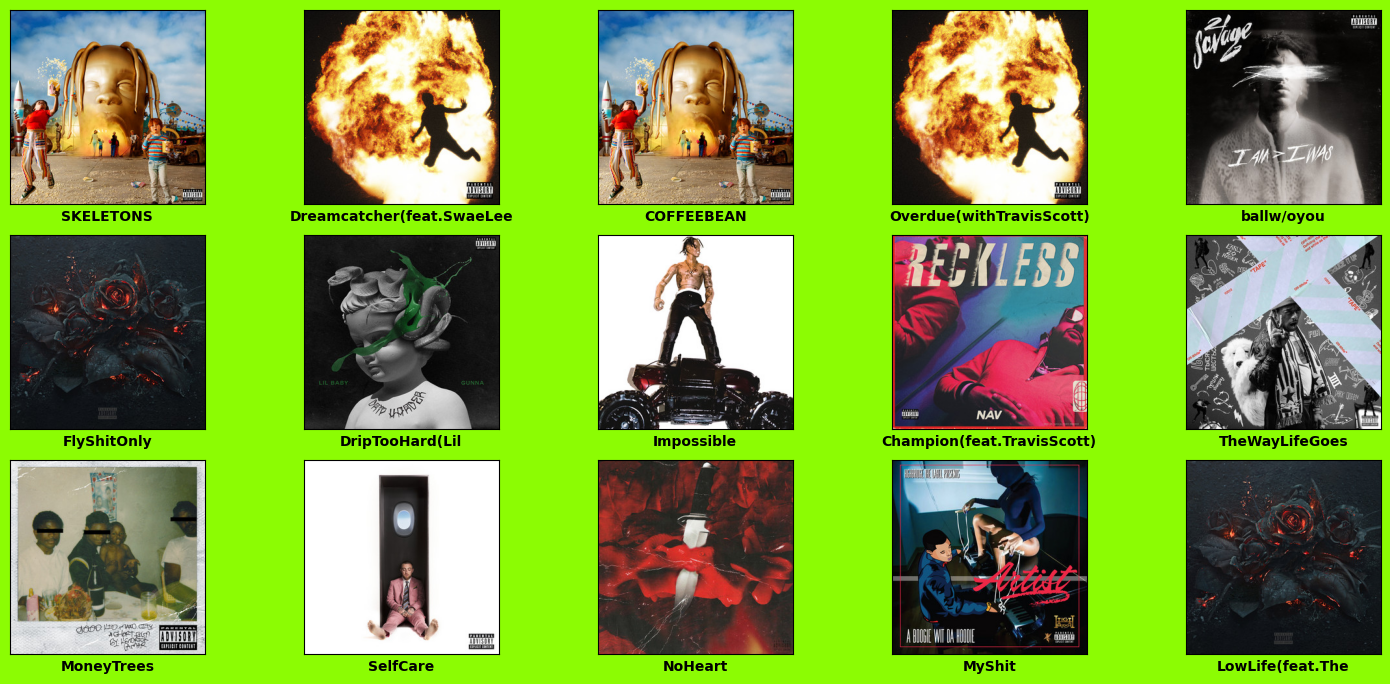

In [ ]:
visualize_cover_art(playlist_df)


In [ ]:
def generate_playlist_vector(spotify_features, playlist_df, weight_factor):
    
    spotify_features_playlist = spotify_features[spotify_features['track_id'].isin(playlist_df['track_id'].values)]
    spotify_features_playlist = spotify_features_playlist.merge(playlist_df[['track_id','date_added']], on = 'track_id', how = 'inner')
    
    spotify_features_nonplaylist = spotify_features[~spotify_features['track_id'].isin(playlist_df['track_id'].values)]
    
    playlist_feature_set = spotify_features_playlist.sort_values('date_added',ascending=False)
    
    
    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'days_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days)
        
    
    playlist_feature_set['weight'] = playlist_feature_set['days_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-3].mul(playlist_feature_set_weighted.weight.astype(int),0))   
    
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-3]
    

    
    return playlist_feature_set_weighted_final.sum(axis = 0), spotify_features_nonplaylist

In [ ]:
playlist_vector, nonplaylist_df = generate_playlist_vector(spotify_features_df, playlist_df, 1.2)
#print(playlist_vector.shape)
print(nonplaylist_df.head())

                 track_id  acousticness  danceability  duration_ms    energy  \
0  0BRjO6ga9RKCKjfDqeFgWV      0.000025      0.000022          1.0  0.000028   
1  0BjC1NfoEOOusryehmNudP      0.000042      0.000045          1.0  0.000046   
2  0CoSDzoNIKCRs124s9uTVy      0.000087      0.000085          1.0  0.000082   
3  0Gc6TVm52BwZD07Ki6tIvf      0.000084      0.000081          1.0  0.000082   
4  0IuslXpMROHdEPvSl1fTQK      0.000267      0.000260          1.0  0.000259   

   instrumentalness  liveness  loudness  speechiness     tempo  ...  B  C  C#  \
0          0.000018  0.000022       0.0     0.000019  0.001699  ...  0  0   1   
1          0.000040  0.000042       0.0     0.000041  0.001307  ...  0  0   0   
2          0.000082  0.000082       0.0     0.000082  0.000666  ...  0  1   0   
3          0.000080  0.000081       0.0     0.000080  0.001207  ...  0  0   1   
4          0.000257  0.000258       0.0     0.000256  0.001957  ...  0  0   0   

   D  D#  E  F  F#  G  G#  
0  0

In [ ]:
def generate_recommendation(spotify_data, playlist_vector, nonplaylist_df):

    non_playlist = spotify_data[spotify_data['track_id'].isin(nonplaylist_df['track_id'].values)]
    non_playlist['sim'] = cosine_similarity(nonplaylist_df.drop(['track_id'], axis = 1).values, playlist_vector.drop(labels = 'track_id').values.reshape(1, -1))[:,0]
    non_playlist_top15 = non_playlist.sort_values('sim',ascending = False).head(15)
    non_playlist_top15['url'] = non_playlist_top15['track_id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return  non_playlist_top15

In [ ]:
# in this function, we want to generate recommendation for the playlist based on the playlist vector 
#in such a way that we are suggesting songs that minimize the cosine similarity between the playlist and the nonplaylist while simultaneously randomly sampling across a variety of artists based on popularity
def generate_recommendation_updated(spotify_data,playlist_vector,nonplaylist_df):

  non_playlist = spotify_data[spotify_data['track_id'].isin(nonplaylist_df['track_id'].values)]
  non_playlist['sim'] = cosine_similarity(nonplaylist_df.drop(['track_id'], axis = 1).values, playlist_vector.drop(labels = 'track_id').values.reshape(1, -1))[:,0]

  non_playlist_top500 = non_playlist.sort_values('sim',ascending = False).head(25)
  non_playlist_top500['url'] = non_playlist_top500['track_id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])


  return non_playlist_top500

In [ ]:
top500 = generate_recommendation_updated(spotify_data, playlist_vector, nonplaylist_df)  
top500.head()

<ipython-input-19-614a7e1a57ad>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_playlist['sim'] = cosine_similarity(nonplaylist_df.drop(['track_id'], axis = 1).values, playlist_vector.drop(labels = 'track_id').values.reshape(1, -1))[:,0]


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,sim,url
119480,Rap,Lil Pump,Crazy,1iDPB2WNsGEWuKycQyDGn6,60,0.000058,0.000065,1.0,0.000061,0.000058,C#,0.000059,0.0,Major,0.000060,0.001159,4/4,0.000062,0.793212,https://i.scdn.co/image/ab67616d00001e02d52ef1...
119068,Rap,Jhene Aiko,Sing To Me,6QbM2D1CI7cbt6c8G1d3EL,57,0.000067,0.000069,1.0,0.000068,0.000065,C#,0.000066,0.0,Minor,0.000066,0.001191,4/4,0.000066,0.793212,https://i.scdn.co/image/ab67616d00001e027ccc80...
120203,Rap,Ski Mask The Slump God,New Age Chip Skylark,2jDtVZi6Js9McXD7qxBzNv,54,0.000054,0.000058,1.0,0.000057,0.000052,C#,0.000053,0.0,Major,0.000053,0.001169,4/4,0.000056,0.793212,https://i.scdn.co/image/ab67616d00001e024277d2...
118987,Rap,XXXTENTACION,Maxipads for Everyone,39wqiOEjFN3HaXs19jf2Xb,56,0.000074,0.000080,1.0,0.000076,0.000073,C#,0.000074,0.0,Major,0.000074,0.001182,4/4,0.000074,0.793212,https://i.scdn.co/image/ab67616d00001e0281e8db...
87151,Rap,XXXTENTACION,Look At Me!,7floNISpH8VF4z4459Qo18,83,0.000053,0.000057,1.0,0.000056,0.000051,C#,0.000051,0.0,Major,0.000053,0.001151,4/4,0.000053,0.793212,https://i.scdn.co/image/ab67616d00001e0271af28...


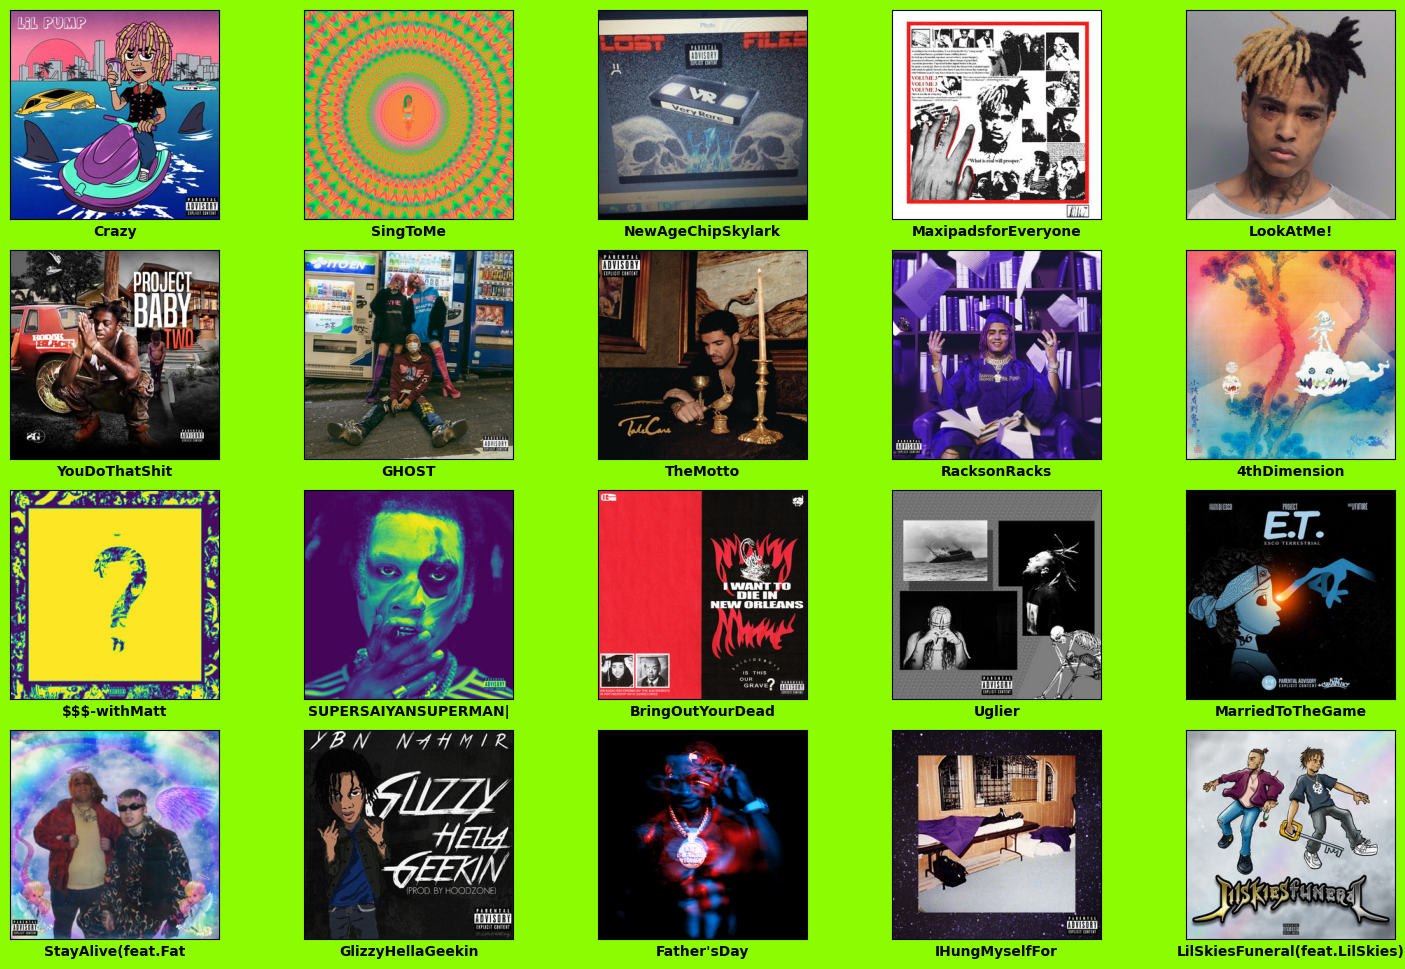

In [ ]:
visualize_cover_art(top500.head(20))

In [ ]:
top500.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,sim,url
119480,Rap,Lil Pump,Crazy,1iDPB2WNsGEWuKycQyDGn6,60,0.000058,0.000065,1.0,0.000061,0.000058,C#,0.000059,0.0,Major,0.000060,0.001159,4/4,0.000062,0.793212,https://i.scdn.co/image/ab67616d00001e02d52ef1...
119068,Rap,Jhene Aiko,Sing To Me,6QbM2D1CI7cbt6c8G1d3EL,57,0.000067,0.000069,1.0,0.000068,0.000065,C#,0.000066,0.0,Minor,0.000066,0.001191,4/4,0.000066,0.793212,https://i.scdn.co/image/ab67616d00001e027ccc80...
120203,Rap,Ski Mask The Slump God,New Age Chip Skylark,2jDtVZi6Js9McXD7qxBzNv,54,0.000054,0.000058,1.0,0.000057,0.000052,C#,0.000053,0.0,Major,0.000053,0.001169,4/4,0.000056,0.793212,https://i.scdn.co/image/ab67616d00001e024277d2...
118987,Rap,XXXTENTACION,Maxipads for Everyone,39wqiOEjFN3HaXs19jf2Xb,56,0.000074,0.000080,1.0,0.000076,0.000073,C#,0.000074,0.0,Major,0.000074,0.001182,4/4,0.000074,0.793212,https://i.scdn.co/image/ab67616d00001e0281e8db...
87151,Rap,XXXTENTACION,Look At Me!,7floNISpH8VF4z4459Qo18,83,0.000053,0.000057,1.0,0.000056,0.000051,C#,0.000051,0.0,Major,0.000053,0.001151,4/4,0.000053,0.793212,https://i.scdn.co/image/ab67616d00001e0271af28...


In [ ]:
new = spotify_data[spotify_data['track_id'].isin(nonplaylist_df['track_id'].values)]

In [ ]:
# print the shape of the dataframe new

print(new)

        genre               artist_name                        track_name  \
0       Movie            Henri Salvador       C'est beau de faire un Show   
1       Movie         Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2       Movie           Joseph Williams    Don't Let Me Be Lonely Tonight   
3       Movie            Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4       Movie              Fabien Nataf                         Ouverture   
...       ...                       ...                               ...   
232720   Soul                     Slave                      Son Of Slide   
232721   Soul  Jr Thomas & The Volcanos                      Burning Fire   
232722   Soul              Muddy Waters    (I'm Your) Hoochie Coochie Man   
232723   Soul                   R.LUM.R                     With My Words   
232724   Soul            Mint Condition    You Don't Have To Hurt No More   

                      track_id  popularity  acousticness  danceability  \
0

In [ ]:
# print the average of all of the various features of each song in new

new2 = spotify_data[spotify_data['track_id'].isin(top500['track_id'].values)]

print(new2.values)


[['Alternative' 'Jhene Aiko' 'Sing To Me' ... 0.0011906051745694923 '4/4'
  6.643161455972807e-05]
 ['Dance' 'Jhene Aiko' 'Sing To Me' ... 0.0011906051745694923 '4/4'
  6.643161455972807e-05]
 ['R&B' 'Jhene Aiko' 'Sing To Me' ... 0.0011906051745694923 '4/4'
  6.643161455972807e-05]
 ...
 ['Pop' 'Jhene Aiko' 'Sing To Me' ... 0.0011906051745694923 '4/4'
  6.643161455972807e-05]
 ['Pop' 'Future' 'Married To The Game' ... 0.001143461897873304 '4/4'
  4.5069469962578576e-05]
 ['Soul' 'Roy Woods' 'Russian Cream' ... 0.0012399449667841362 '4/4'
  6.67930919771533e-05]]


In [ ]:
for val in top500.values:
  print(val)

['Rap' 'Lil Pump' 'Crazy' '1iDPB2WNsGEWuKycQyDGn6' 60 5.78642059648222e-05
 6.49475002914572e-05 1.0000000000000002 6.096264812799512e-05
 5.7648592721508614e-05 'C#' 5.855895974883262e-05 0.0 'Major'
 6.021998028991501e-05 0.0011594642087566144 '4/4' 6.160948785793587e-05
 0.7932124409051035
 'https://i.scdn.co/image/ab67616d00001e02d52ef190ae5253eb2c3c764c']
['Rap' 'Jhene Aiko' 'Sing To Me' '6QbM2D1CI7cbt6c8G1d3EL' 57
 6.746303492878617e-05 6.91187360475373e-05 1.0 6.8392670393003e-05
 6.509489315071937e-05 'C#' 6.613983116584981e-05 0.0 'Minor'
 6.645875720101908e-05 0.0011906051745694923 '4/4' 6.643161455972807e-05
 0.7932124408733765
 'https://i.scdn.co/image/ab67616d00001e027ccc8005498d9f75b03333c2']
['Rap' 'Ski Mask The Slump God' 'New Age Chip Skylark'
 '2jDtVZi6Js9McXD7qxBzNv' 54 5.394714709139619e-05 5.777507997081869e-05
 1.0 5.711146369996744e-05 5.1673047431527854e-05 'C#'
 5.263610031239736e-05 0.0 'Major' 5.3404924040822604e-05
 0.0011690652685620653 '4/4' 5.627789692072

In [ ]:
# Calculate the average of each column
col_means = top500.mean()

# Convert the column means to a dictionary
col_means_dict = col_means.to_dict()

print(col_means_dict)

{'popularity': 61.84, 'acousticness': 5.7424579406904574e-05, 'danceability': 6.236000739879344e-05, 'duration_ms': 1.0, 'energy': 6.0929789677723655e-05, 'instrumentalness': 5.6508608872902165e-05, 'liveness': 5.828619268220392e-05, 'loudness': 0.0, 'speechiness': 5.822320644110691e-05, 'tempo': 0.0011617457334361808, 'valence': 5.920811863585694e-05, 'sim': 0.793212440555624}


<ipython-input-27-094abb6dbb47>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  col_means = top500.mean()


In [ ]:
playlist_vector

track_id            78QR3Wp35dqAhFEc2qAGjE2eAZfqOm4EnOF9VvN50Tyc4g...
acousticness                                                 0.001377
danceability                                                 0.001457
duration_ms                                                      38.0
energy                                                       0.001429
instrumentalness                                             0.001331
liveness                                                     0.001374
loudness                                                          0.0
speechiness                                                  0.001352
tempo                                                        0.024936
valence                                                        0.0014
A Capella                                                           0
Alternative                                                         0
Anime                                                               0
Blues               

In [ ]:
col_means_input_playlist = nonplaylist_df.mean()
col_means_in_dict = col_means_input_playlist.to_dict()

print(col_means_in_dict)

{'acousticness': 5.330796738068098e-05, 'danceability': 5.407278450796254e-05, 'duration_ms': 1.0, 'energy': 5.405961463954113e-05, 'instrumentalness': 5.207243911508613e-05, 'liveness': 5.2382335148412306e-05, 'loudness': 1.0521962881403637e-09, 'speechiness': 5.194800342179516e-05, 'tempo': 0.0006440904029109222, 'valence': 5.3614568424522694e-05, 'A Capella': 0.0005114166240486146, 'Alternative': 0.03980884192069174, 'Anime': 0.03840352060923043, 'Blues': 0.03877741343521555, "Children's Music": 0.0232200337792829, 'Children’s Music': 0.04019562760274532, 'Classical': 0.039778758589865355, 'Comedy': 0.04160524653289612, 'Country': 0.037234568325690734, 'Dance': 0.03739358021720165, 'Electronic': 0.04029877045129294, 'Folk': 0.039963556193513175, 'Hip-Hop': 0.03990338953186039, 'Indie': 0.04101217515374731, 'Jazz': 0.04057381804741993, 'Movie': 0.033547211490113325, 'Opera': 0.03558428274892882, 'Pop': 0.040281579976535004, 'R&B': 0.03864418725584154, 'Rap': 0.03961115146097547, 'Reg

<ipython-input-29-dccfd39d7486>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  col_means_input_playlist = nonplaylist_df.mean()
